In [1]:
%matplotlib inline

# Outline

- Localise the sudoku puzzle in the image.
- Using the corners of the puzzle we will perform an affine transform to bring it in a canonical frame.
- After warping the original image to a canonical frame it will be easy to split it as a 9 * 9 grid and extract bounding boxes for each of the cells.
- We will use a digit classifier to classify each of one of the cells independently.
- Using the parsed grid solve the sudoku using a simple brute force algorithm.

## Imports

In [2]:
import tensorflow as tf
import menpo.io as mio
import cv2
import numpy as np
import menpowidgets

from menpo.image import Image
from menpo.shape import PointCloud, bounding_box
from menpo.transform import PiecewiseAffine

SUDOKU_SIZE = 9
REFERENCE_CELL_SIZE = 28
CELL_SHAPE = (REFERENCE_CELL_SIZE, REFERENCE_CELL_SIZE)
EMPTY_CELL = 10 # Magic number that represents an empty cell.

## Load an image of a sudoku puzzle.

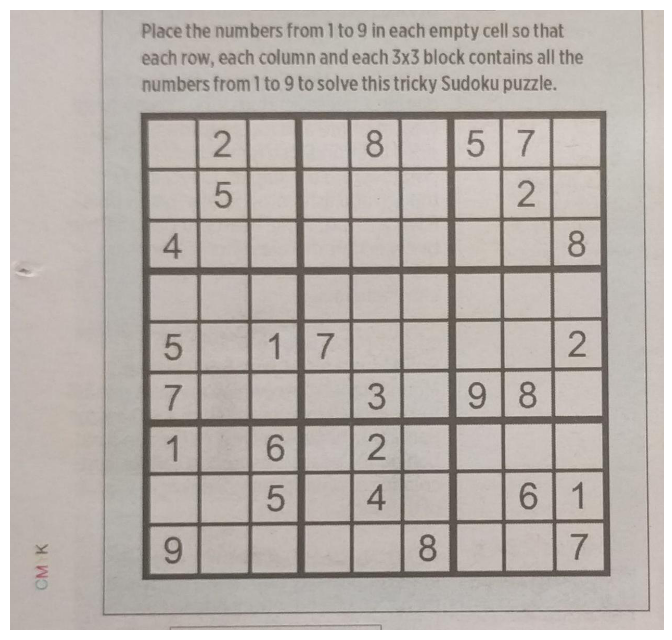

In [3]:
im = mio.import_images('data/*.jpg', normalize=False)[0]
im.view()

# Detect the sudoku puzzle in the image.

In order to localise the corners of the puzzle we will apply a thresholding algorithm to segment the
lines/text from the background. As there is a large variation in the background intensity due to lighting
and in the wild conditions we use a local/dynamic thresholding.

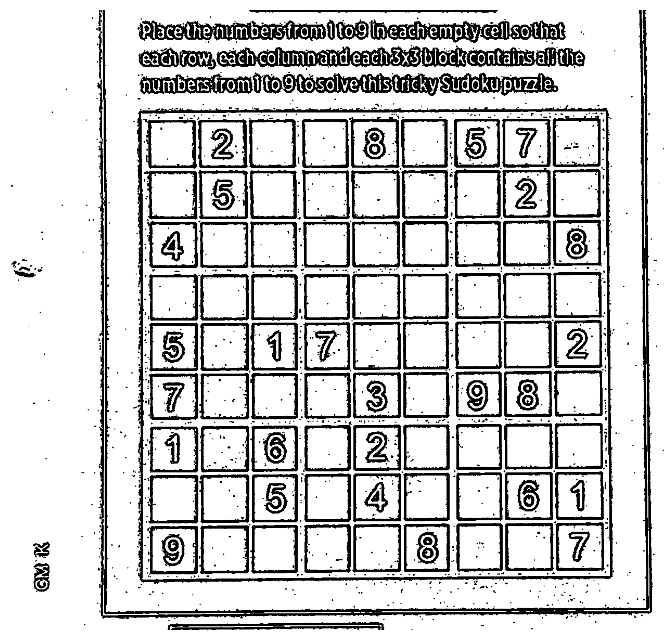

In [4]:
gray = im.as_greyscale().pixels.squeeze()

def preprocess_image(gray_image, blur_kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    
    im = cv2.medianBlur(gray_image, blur_kernel_size)
    im = cv2.bitwise_not(im, im)

    im = cv2.adaptiveThreshold(
            im,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
            thresholdType=cv2.THRESH_BINARY,
            blockSize=5,
            C=2)
    return cv2.erode(im, kernel)

preprocessed = preprocess_image(gray)
Image(preprocessed).view()

After preprocessing the image to make the edges more apparent we can use a contour finding algorithm.
The marching squares algorithm aims at drawing lines between interpolated values along the edges of a square, considering given weights of the corners and a reference value. 

In [5]:
contours, _ = cv2.findContours(preprocessed.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [6]:
def approximated_shape(contour):
    """Approximates the shape of a complex contour with a simpler one."""
    length = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.02 * length, True)

def shape_to_pc(shape):
    """Converts an opencv shape to a `menpo.PointCloud`."""
    return PointCloud(approximated_shape(shape)[::-1, 0, [1, 0]])

As we know that a (normal) sudoku puzzle has 4 corners
we simplify all the shapes we found with simpler ones with
less vertices so that the distance between the corners is less or equal.

In [7]:
# Sort the contours by descenting size.
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Simplify the contours.
shapes = map(approximated_shape, contours)

# Gets the 30 largest shapes with 4 edges.
rectangles = [shape_to_pc(x) for x in shapes if len(x) == 4][:30]

Now we can visualise the results on the original image.

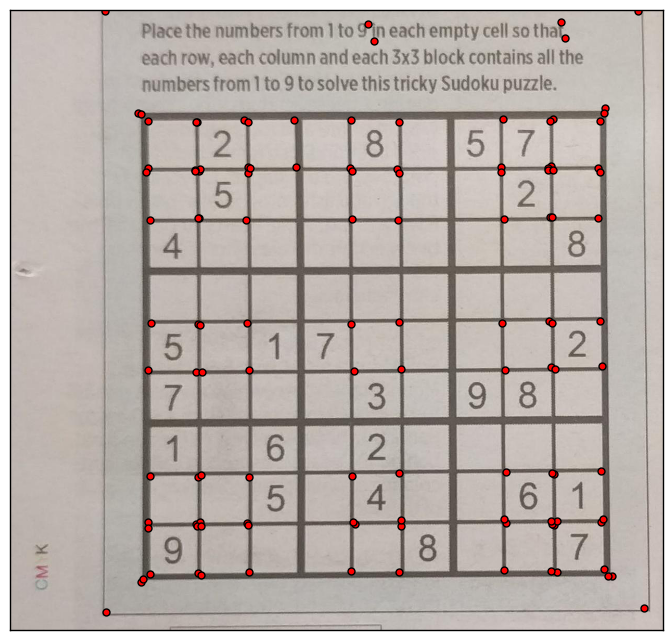

In [8]:
im.view()
for box in rectangles:
    box.view()

Notice that one could expect that the largest found rectangle is the one
containing the puzzle, this assumption can fail, as in the example above.

To circumvent this we will pick the median rectangle in area ($a_{median}$) from those we
found, hoping that is one of the 81 cells inside the puzzle. Then 
the area of the actually puzzle should be roughly 81 times that.

$$ a_{sudoku} = 9 \times 9 \times a_{cell} \approx 9 \times 9 \times a_{median} $$

In [9]:
def get_area(pc):
    min_points, max_points = pc.bounds()
    return np.multiply(*(max_points - min_points))

# Finds the median area of the largest 30 bounding boxes.
median_box = np.median([get_area(x) for x in rectangles])

# Calculates the approximate size of the sudoku.
approx_size_of_sudoku = median_box * SUDOKU_SIZE**2

Then we simply get the rectangle with the smallest deviation from the approximated size

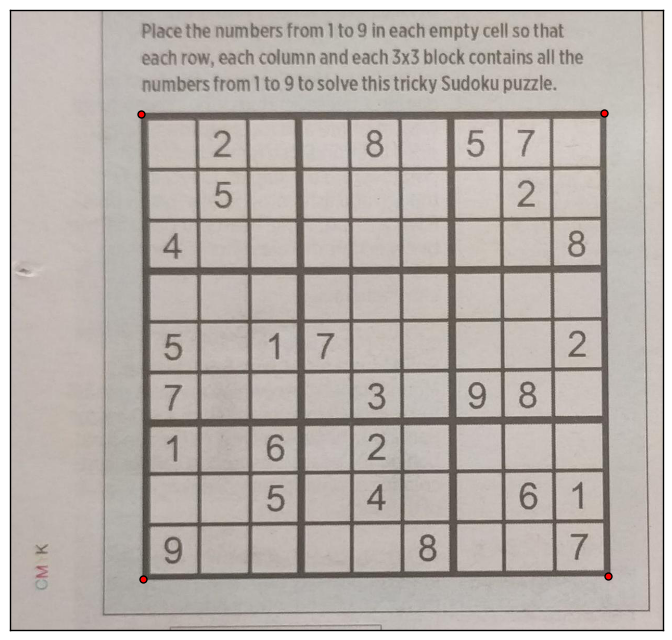

In [10]:
box = min(rectangles, key=lambda x: abs(get_area(x) - approx_size_of_sudoku))

im.view()
box.view()

Having found the corners of the puzzle, then we can wrap the image
to a canonical frame so we can easily perform further analysis on the
image. We define each cell in the reference shape to have a shape
of (30, 30), two pixels larger in each dimension that the receptive 
field of our neural network (28, 28).

In [11]:
reference_shape = [(REFERENCE_CELL_SIZE + 2) * SUDOKU_SIZE] * 2
reference_box = bounding_box((0, 0), reference_shape)

In [12]:
def sort_points(box):
    """This function makes sure that the order of the points in our `PointCloud`
    follows the same convention as our reference box.

    The the first point (0) should be nearest the origin.
    This ordering would appear as:

        0<--3
        |   ^
        |   |
        v   |
        1-->2
    """
    centre = box.centre()

    lower = box.points < centre

    lower_left = np.all(lower == [True, False], 1)
    upper_right = np.all(lower == [False, True], 1)
    lower_right = np.all(lower == [False, False], 1)
    upper_left = np.all(lower == [True, True], 1)

    sorted_points = [
        box.points[upper_left],
        box.points[upper_right],
        box.points[lower_right],
        box.points[lower_left]
    ]
    
    return PointCloud(np.array(sorted_points).squeeze())

box = sort_points(box)

We now can warp our initial image to our reference frame using 
an affine transform which will account for translation, scaling, rotation and shearing.

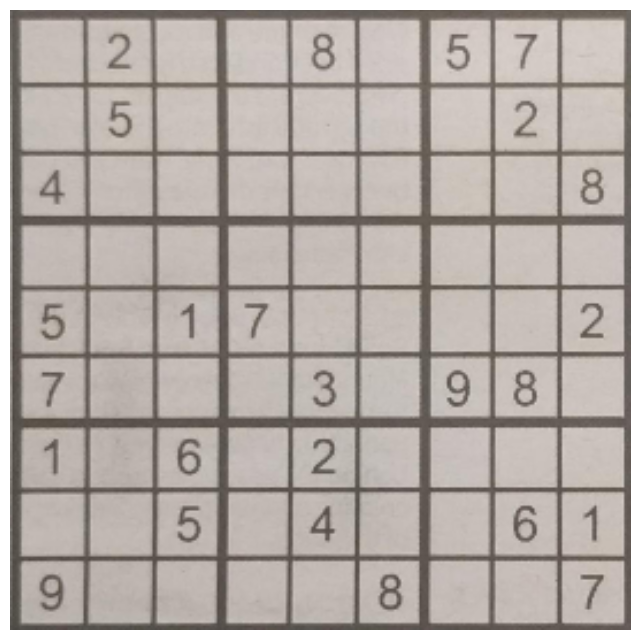

In [13]:
image_transform = PiecewiseAffine(reference_box, box)
warped_image = im.warp_to_shape(reference_shape, image_transform)
warped_image.view()

Now it's very easy to split the reference frame into a nine
by nine grid of smaller cells. We calculate the expected centres
of the these cells and then extract 28x28 patches on our warped space. At this stage we could also perform a local bounding box detection to correct for local deformations and align each of the patches to another 28x28 reference grid and/or find the barycenter of the patch using a connected components algorithm. We opt out of this approach though for clarity of presentation.

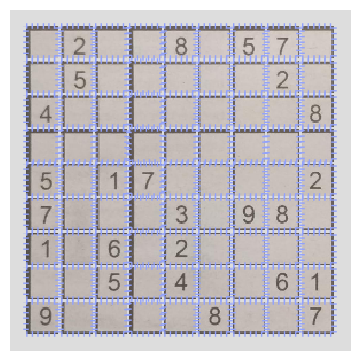

In [14]:
centres_of_cells = np.array(
    [
        [y, x]
        for y in range(REFERENCE_CELL_SIZE//2+1, warped_image.shape[0], 30)
        for x in range(REFERENCE_CELL_SIZE//2+1, warped_image.shape[1], 30)
    ], int)

patches = warped_image.extract_patches(PointCloud(centres_of_cells), patch_shape=CELL_SHAPE)
menpowidgets.visualize_patches(patches, PointCloud(centres_of_cells))

## Digit classification model

To actually classify each of the cells in our sudoku puzzle
we will make use of a convolutional neural network based classifier.

The network is comprised of 3 hidden layers -- 2 convolutionals and a fully-connected one. Each of this is followed by a batchnorm and a ReLU nonlinearity. Finally the task loss is to maximize the crossentropy for our 11 classes (10 for the digits and one for the background).

    conv2d: (filters=128, kernel_size=(5, 5))
    max_pool2d: (size=(2, 2))
    conv2d: (filters=64, kernel_size=(5, 5))
    max_pool2d: (size=(2, 2))
    dropout
    fully_connected: (units=1024, scope='fc3')
    fully_connected: (units=11, activation_fn=None)
    
The model is defined in `digit_train.py`.


## Training the model.

To train our convnet we use the traditional MNIST dataset for handwritten digits [1] and a very small dataset [2] of cells from sudoku puzzles.

    [1] http://yann.lecun.com/exdb/mnist/
    [2] https://github.com/eatonk/sudoku-image-solver/tree/master/ocr_data

### Data augmentation.
As the domain specific data we have are very few we can add some domain specific knowledge in the training process by using data augmentation. As we train the network with stochastic optimization we add different amounts of brightness and contrast for each of the images in our minibatch. To also be more robust to translation invariance and bad bounding boxes we resample each of the images to have resolution 33x33 pixels and then we randomly crop patches of size 28x28 pixels. Other possible augmentation techniques (in the lack of representative training data) could be doing affine transforms (rotation/shearing etc.) of the training images.

    - random_brightness
    - random_contrast
    - resize_images to (33, 33)
    - random_crop of size (28, 28)

### Loading the model.

Having training the model we freeze the final weights to a single TensorFlow graph using the 
    `tensorflow/python/tools/freeze_graph.py` script contained in the TensorFlow framework.

In [15]:
image = tf.placeholder(tf.float32, shape=(None, REFERENCE_CELL_SIZE, REFERENCE_CELL_SIZE, 1))

with open('mnist_model.pb', 'rb') as f:
    graph_def = tf.GraphDef.FromString(f.read())
    pred,  = tf.import_graph_def(graph_def, input_map={"images": image}, return_elements=['softmax:0'])

In [16]:
# Initialise a session for running TensorFlow operations.
sess = tf.Session()

As the alignment to our reference shape will not be exact, we can increase robustness
wrt. the classification result by randomly permuting the centres of the cell bounding boxes
many times and then averaging the predictions of the model.

In [17]:
number_of_random_permutations = 10

all_predictions = []

for i in range(number_of_random_permutations):
    random_pcs = centres_of_cells - np.random.randint(-2, 2, size=centres_of_cells.shape)
    patches = warped_image.extract_patches(PointCloud(random_pcs), patch_shape=(28, 28))
    preds = sess.run(pred, feed_dict={image: patches[:, 0, 0][..., None] / 255.})
    
    all_predictions.append(preds)
    
# Prediction will be a 9x9x11 np.array containing the unnormalised log-probabilities
# for each of the 11 classes (10 digits, 1 background), one for each cell in the grid. 
prediction = np.mean(all_predictions, 0).reshape(SUDOKU_SIZE, SUDOKU_SIZE, -1)

# The maximum likelihood estimate of our model.
grid = prediction.argmax(2)

# In the case we misclassified a digit as 0
# we pick the next most probable class.
grid[grid==0] = prediction[grid==0].argsort(-1)[:, -2]

In [18]:
def text_representation(grid):
    """Converts our 2D grid format to text."""
    text = grid.astype(str)
    text[text == str(EMPTY_CELL)] = '*'

    return '\n'.join(' '.join(l) for l in text)

print text_representation(grid)

* 2 * * 8 * 5 7 *
* 5 * * * * * 2 *
4 * * * * * * * 8
* * * * * * * * *
5 * 1 7 * * * * 2
7 * * * 3 * 9 8 *
1 * 6 * 2 * * * *
* * 5 * 4 * * 6 1
9 * * * * 8 * * 7


We cannot expect our model to be perfect and it will be (almost) unavoidable to have classification mistakes at times. One approach we can take to correct such mistakes is to find a board configuration ($c$) with the highest probability of being correct subject to being a valid configuration. A valid configuration ($valid(c)$) is one that does not have any conflicts with the rules of the game. That is every detected digit is unique in its row, column, and block.
The optimisation problem we are trying to solve then is

$$ \max prob(c) \\ \text{subject to:}\; valid(c),$$

where $prob(c) = \sum_{ij} prob(c_{ij})$ is the sum of the maximum likelihood estimates for every cell in our board configuration. To solve this problem we will use a simple greedy algorithm that works as follows:

- Find the cells that violate the rules of the game (`get_conflicts`)
- Remove them from the MLE grid.
- Until there are no conflicting cells left:
  - Add the cell with the highest probability of being correct back on the grid as long as it does not violate the rules of the game.
  - Remove the cell from the list of conflicting cells.

In [19]:
def find_duplicates(xs):
    return np.ravel([x for x in [np.argwhere(i==xs) for i in (set(xs) - set([EMPTY_CELL]))] if len(x) > 1])

def get_conflicts(grid):
    conflicts = []

    for i in range(SUDOKU_SIZE):
        # Finds the duplicates in all the rows.
        idx = find_duplicates(grid[i])
        conflicts += [(i, int(x)) for x in idx]

        # Finds the duplicates in all the columns.
        idx = find_duplicates(grid[:, i])
        conflicts += [(int(x), i) for x in idx]

    
    for i in range(0, SUDOKU_SIZE, 3):
        for j in range(0, SUDOKU_SIZE, 3):
            
            # Finds the duplicates in all the 3x3 blocks.
            idx = find_duplicates(grid[i:i+3, j:j+3].ravel())
            
            conflicts += [(i+x//3, j+x%3) for x in idx]

    return conflicts

def make_puzzle_valid(prediction, grid, conflicts):
    found_conflicts = get_conflicts(grid)

    if len(found_conflicts) == 0:
        return
    
    for position in found_conflicts:
        grid[position] = EMPTY_CELL

    conflicts += found_conflicts
    position = max(conflicts, key=lambda x: prediction[x].max())
    
    grid[position] = prediction[position].argmax()

    if len(get_conflicts(grid)) > 0:
        grid[position] = EMPTY_CELL

    conflicts = set(conflicts).remove(position)

    return make_puzzle_valid(prediction, grid, conflicts)

In [20]:
make_puzzle_valid(prediction, grid, [])

# Solving the puzzle.

At this point we have a valid configuration, which is hopefully the same as in the provided image.
To reliably find a solution we can brute force the different possibilities until we fill the cells
in the grid and there are no conflicts.

- find an empty cell in the grid.
- find the set of values that are valid for that configuration.
- for each possible value:
    - place that value there.
    - solve the rest of the puzzle recursively.

In [21]:
def solve(grid):
    pos = find_empty_cell(grid) 
    if not pos:
        return True

    for n in find_possible_values(grid, pos):
        grid[pos] = n

        if solve(grid):
            return True

    # Failed to find a solution put the original value back.
    grid[pos] = EMPTY_CELL

In [22]:
def find_empty_cell(grid):
    ys, xs = np.where(grid == EMPTY_CELL)
    
    try:
        return zip(ys, xs)[0]
    except IndexError:
        pass
    
def get_cell_contents(grid, (y, x), cell_size=3):
    """Gets the 3x3 cells contents that the cell at (y, x) belongs."""
    top = (y // cell_size) * cell_size
    left = (x // cell_size) * cell_size

    return grid[top:top+cell_size, left:left+cell_size].ravel()
    
def find_possible_values(grid, (y, x)):
    return set(range(1, SUDOKU_SIZE+1)) - \
            set(grid[y]) - \
            set(grid[:, x]) - \
            set(get_cell_contents(grid, (y, x)))

And finally we can visualise the solved board.

Found a solution!


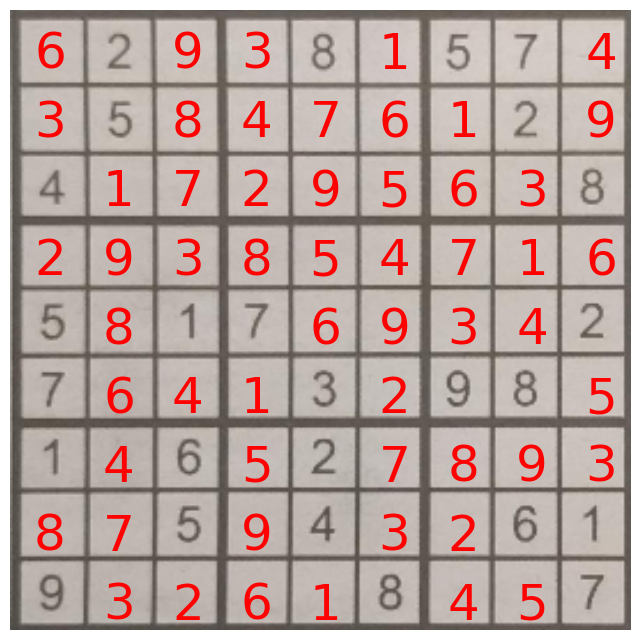

In [23]:
original_grid = grid.copy()
solved_grid = grid.copy()

def visualise_grid(warped_image, original_grid, solved_grid):
    warped_image.view()

    for i in range(SUDOKU_SIZE):
        for j in range(SUDOKU_SIZE):
            y, x = centres_of_cells.reshape(SUDOKU_SIZE, SUDOKU_SIZE, -1)[i, j]
            if original_grid[i, j] == EMPTY_CELL and solved_grid[i, j] != EMPTY_CELL:
                plt.text(x-5, y+10, solved_grid[i, j], fontdict={'fontsize': 36, 'color': 'red'})

if solve(solved_grid):
    print('Found a solution!')
    visualise_grid(warped_image, original_grid, solved_grid)
else:
    print('No solution found.')

There is a number of ways to improve on the results.

- Instead of using a holistic method to do perpective correction on the whole grid we could have used a reference grid with the same amount of lines of
blocks and cells and use a Lucas–Kanade algorithm to do alignment.
- Collect representative examples of sudoku puzzles and having them annotated to improve on the classification results.
- For solving the puzzle we could have used heuristics to speed up the search time, or use a more efficient data structure to find the conflicts in the grid (e.g., bitmaps).
- Having enough training data it would be interesting to train an end-to-end method for parsing the grid (e.g., with a combination of Spatial Transformer Nets [1] and a recurrent network.)

[1] Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial transformer networks." Advances in Neural Information Processing Systems. 2015.